# Daniel Jones - 7929997 - Speech Emotion Recognition Classifier - 303COM

In [1]:
"""Import libraries"""
import glob
import numpy as np
import matplotlib.pyplot as plt
import time
import librosa
import librosa.display
import IPython.display as ipd
import pydub
from tqdm import tqdm
from scipy.signal.signaltools import wiener
import pandas as pd
import json

import keras
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from keras.models import Model, Sequential
from keras import optimizers
from keras.layers import Input, Conv1D, Conv2D,BatchNormalization, MaxPooling1D,MaxPooling2D, LSTM, Dense, Activation, Layer,Reshape
from keras.models import model_from_json
from keras import regularizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.callbacks import  History, ReduceLROnPlateau, CSVLogger
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from sklearn.metrics import accuracy_score

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


## Transforming audio into mel-spectrograms

Turning audio samples into mel-spectrograms converts the problem of audio classification into image classification.
With image classification, we can later utilise convolutional neural networks to detect features.

### Example audio for training

In [3]:
EXAMPLE = "Train/Actor_01/03-01-01-01-01-02-01.wav"
display(ipd.Audio(EXAMPLE))


### Helper functions
The `convert_audio` function takes the audio and converts it into a mel-spectrogram - an numpy ndarray with the weight values is returned. This is what the model will be trained on.

The `get_label_RAVDESS` simply returns the corresponding emotion label from the post-processed audio files. This is required for classification purposes.

(128, 259, 1)
Emotion: male_sad


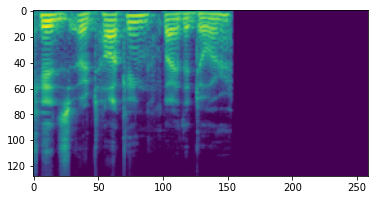

In [5]:
def convert_audio(path, audio_duration=3):
    """Given a path to an audio file, extract the log-scaled mel-spectrogram"""
    input_length = sampling_rate * audio_duration
    signal, sample_rate = librosa.load(path, sr=44100) # 22050 * 2
    signal, index = librosa.effects.trim(signal, top_db=25)
    # Apply wiener filtering
    signal = wiener(signal)
    # For chunking the audio into uniform amounts
    if len(signal) > input_length:
        signal = signal[0:input_length]
    elif input_length > len(signal):
        max_offset = input_length - len(signal)  
        signal = np.pad(signal, (0, max_offset), "constant")
    # Convert the processed signal into the log mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(signal, sr=sample_rate, n_fft=2048, hop_length=512, n_mels=128)
    # Convert the spectrogram into decibel units (i.e. weighted matrix)
    lms = librosa.power_to_db(mel_spectrogram)
    lms = np.expand_dims(lms, axis=-1)
    return lms

def get_label_RAVDESS(path):
    """Given a path to a RAVDESS audio file, extract the emotion and return the label"""
    path = path.split("\\")
    gender = path[-2][6:8]
    if int(gender) % 2:
        gender = "male"
    else:
        gender = "female"
    emotion = path[-1][6:8]
    # Convert calm to neutral; surprised to happy
    emotions = {"01": "neutral", "02": "neutral",
                "03": "happy", "04": "sad",
                "05": "angry", "06": "fearful",
                "07": "disgust", "08": "happy"}
    label = gender+"_"+emotions[emotion]
    return label


### Visualisation
Converting an example file from the dataset yields the following spectrogram. This is represented by a weighted matrix which will then be utilised in the convolutional neural network.

(128, 259, 1)
Emotion: male_sad


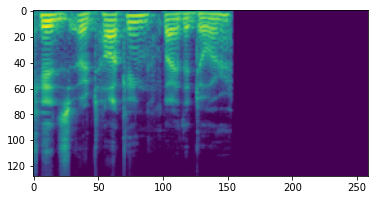

In [7]:
# Testing the functions
EXAMPLE_PATH = "Train\\Actor_01\\03-01-04-01-01-01-01.wav"
display(ipd.Audio(EXAMPLE_PATH))

x = convert_audio(EXAMPLE_PATH)
# librosa.display.specshow(x.reshape(128,259))
plt.imshow(x)
print(x.shape)

EXAMPLE_LABEL = get_label_RAVDESS(EXAMPLE_PATH)
print(f"Emotion: {EXAMPLE_LABEL}")


### Processing the data
This project uses the **RAVDESS Emotional Speech Audio dataset** and only takes speech audio into account. The dataset consists of 1440 unique audio files, 1260 of which are used to train the model.

**RAVDESS Emotional Speech Audio** - https://www.kaggle.com/uwrfkaggler/ravdess-emotional-speech-audio

* The dataset is split into test and train directories. Since the dataset is relatively small, the testing directory consists of a small (size 180) random sampling from the overall dataset.
* For each audio file, the mel spectrogram and emotion label are extracted.

In [8]:
COMPILE_DATA = False
if COMPILE_DATA:
    # Iterate recursively through the train directory and only process .wav files
    TRAIN = glob.glob("Train/*/*.wav")
    TEST = glob.glob("Test/*/*.wav")
    train_dataset = [[convert_audio(path), get_label_RAVDESS(path)] for path in TRAIN]
    test_dataset = [[convert_audio(path), get_label_RAVDESS(path)] for path in TEST]
    np.save("train_dataset.npy", train_dataset)
    np.save("test_dataset.npy", test_dataset)
else:
    train_dataset = np.load("train_dataset.npy", allow_pickle=True)
    test_dataset = np.load("test_dataset.npy", allow_pickle=True)


In [42]:
# Build the training and testing variables
le = LabelEncoder()
x_train = np.array([i[0] for i in train_dataset])
y_train = np.array([i[1] for i in train_dataset])

x_test = np.array([i[0] for i in test_dataset])
y_test = np.array([i[1] for i in test_dataset])

# Convert Label encoded normalised labels to binary class matrix
y_train = np_utils.to_categorical(le.fit_transform(y_train))
y_test = np_utils.to_categorical(le.fit_transform(y_test))

# Size of training/testing data and labels respectively
x_train.shape, x_test.shape, y_train.shape, y_test.shape


((1260, 128, 259, 1), (180, 128, 259, 1), (1260, 12), (180, 12))

### Creating the SER Model
The model uses 4 convolutional layers with max pooling, batch normalisation, and an ELU (exponential linear unit) activation function applied to each layer. Softmax activation is used for the final flattened activation function along with the Adam optimiser and categorical crossentropy loss function. The model is constructed with inspiration from the papers A CNN-Assisted Enhanced Audio Signal Processing
for Speech Emotion Recognition (Kwon, S. 2019) and Emotion Recognition from Speech (Venkataramanan, K., & Rajamohan, H.R. 2019), following the champion model architecture with some tweaks. In particular, the data is processed such that less data is lost when transforming the audio into spectrograms (using the high quality 'kaiser fast' resample type) as well as experimental variable modifications.

In [16]:
# Const variables
LABELS = len(np.unique(np.argmax(y_train, 1))) # Number of labels
INPUT_SHAPE = x_train.shape[1:]
LR = 0.0001 # Learning rate
print(f"Number of labels: {LABELS}, Input shape: {INPUT_SHAPE}")


Number of labels: 12, Input shape: (128, 259, 1)


In [48]:
# Model architecture
model = Sequential(name="SER_CNN_2D_DJ")

# keras.backend.clear_session() # For clearing the model

# Add the convolutional layers with batch normalisation and experimental variables
# Layer 1
model.add(Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding="SAME", data_format="channels_last", input_shape=INPUT_SHAPE))
model.add(BatchNormalization())
model.add(Activation("elu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))
# Layer 2
model.add(Conv2D(filters=128,kernel_size=(3,3), strides=(1,1), padding="SAME"))
model.add(BatchNormalization())
model.add(Activation("elu"))
model.add(MaxPooling2D(pool_size=(4,4), strides=(4,4)))
model.add(Dropout(0.25))
# Layer 3
model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding="SAME"))
model.add(BatchNormalization())
model.add(Activation("elu"))
model.add(MaxPooling2D(pool_size=(4,4), strides=(4,4)))
model.add(Dropout(0.25))
# Layer 4
model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding="SAME"))
model.add(BatchNormalization())
model.add(Activation("elu"))
model.add(MaxPooling2D(pool_size=(4,4), strides=(4,4)))
model.add(Dropout(0.25))
# Finally flatten the layers and add the amount of labels + softmax activation function
model.add(Flatten())
model.add(Dense(units=LABELS, activation="softmax"))

# Model compilation
opt = optimizers.Adam(learning_rate=LR, beta_1=0.9,  beta_2=0.999, amsgrad=False)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["categorical_accuracy"])


In [49]:
model.summary()

Model: "SER_CNN_2D_DJ"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 259, 128)     1280      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 259, 128)     512       
_________________________________________________________________
activation (Activation)      (None, 128, 259, 128)     0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 129, 128)      0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 129, 128)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 129, 128)      147584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 129, 128)    

### Training the model
The model is trained in batch sizes of 16 for 125 epochs. These values were experimented with and finally chosen in an attempt to strike a balance between effectiveness and overfitting. As shown in the output, there is consistent improvement but a massive amount of time required (roughly 3 hours of training due to lack of powerful GPU).

In [26]:
#Train Config - had to limit these due to computational hindrances 
BATCH_SIZE = 16
EPOCHS = 125


In [21]:
# Training the model
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.9, patience=20, min_lr=0.000001) # Experimental values; for when val_loss has stopped improving
checkpoint = ModelCheckpoint("model/SER_Model_2DCNN.h5", save_best_only=True, monitor="val_categorical_accuracy", mode="max")
cnnhistory = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(x_test, y_test), callbacks=[checkpoint, reduce_lr])


Epoch 1/125
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpgrhn7sx7.py, line 48)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpgrhn7sx7.py, line 48)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
79/79 [==============================] - 103s 1s/step - loss: 3.3188 - categorical_accuracy: 0.1330 - val_loss: 4.6858 - val_categorical_accuracy: 0.1111
Epoch 2/125
79/79 [==============================] - 92s 1s/step - loss: 2.3938 - categorical_accuracy: 0.2063 - val_loss: 2.1144 - val_categorical_accuracy: 0.2056
Epoch 3/125
79/79 [==============================] - 93s 1s/step 

In [58]:
# Best value categorical accuracy from training
max(cnnhistory.history["val_categorical_accuracy"])

0.6888889074325562

In [21]:
# Load in the model for testing and analysis
model = load_model("model/SER_Model_2DCNN.h5")
model.load_weights("model/SER_Model_2DCNN.h5")


In [23]:
# Evaluate loaded model on test data
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
score = model.evaluate(x_test, y_test, verbose=False)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))


accuracy: 68.89%


In [44]:
# Sample of predictions
predictions = model.predict(x_test, batch_size=BATCH_SIZE, verbose=True)
# Since predictions are weighted across the labels, the argmax (highest weighting) is final prediction
final_prediction = predictions.argmax(axis=1)
pred_flattened = final_prediction.astype(int).flatten()
pred_df = pd.DataFrame({"predictedvalues": (le.inverse_transform((pred_flattened)))})
pred_df[:15]


12/12 [==============================] - 3s 244ms/step


,predictedvalues
0,female_neutral
1,female_neutral
2,female_neutral
3,female_neutral
4,female_neutral
5,female_neutral
6,female_neutral
7,female_neutral
8,female_neutral
9,female_neutral


In [53]:
# Sample the test dataset
y_test = np.array([i[1] for i in test_dataset])
# Compare the sampled dataset against the predictions
actual_df = pd.DataFrame({"actualvalues": y_test})
final_df = pd.concat([actual_df, pred_df], axis=1)
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    print(final_df)


       actualvalues predictedvalues
0    female_neutral  female_neutral
1    female_neutral  female_neutral
2    female_neutral  female_neutral
3    female_neutral  female_neutral
4    female_neutral  female_neutral
5    female_neutral  female_neutral
6    female_neutral  female_neutral
7    female_neutral  female_neutral
8    female_neutral  female_neutral
9    female_neutral  female_neutral
10   female_neutral  female_disgust
11   female_neutral  female_neutral
12     female_happy      female_sad
13     female_happy    female_happy
14     female_happy    female_happy
15     female_happy  female_neutral
16     female_happy    female_happy
17     female_happy    female_happy
18     female_happy    female_happy
19     female_happy    female_happy
20       female_sad  female_neutral
21       female_sad      female_sad
22       female_sad  female_neutral
23       female_sad  female_neutral
24       female_sad  female_neutral
25       female_sad      female_sad
26       female_sad      fem

In [55]:
print(f"Accuracy on test dataset: {accuracy_score(final_df.actualvalues, final_df.predictedvalues) * 100}")

Accuracy on test dataset: 68.88888888888889


### Conclusion
As shown in the predictions made against the test dataset (which the model has never encountered before), the predictions are quite good on average with misclassifications that are relatively close to the actual classification. Notable exceptions are when the model misclassifies the gender of the signal, though this can be explained through pitch variance in speech with the misclassifications generally being attributed to women/men with comparatively low/high pitched voices respectively.